<a href="https://colab.research.google.com/github/Sazonova/avazu_ctr_prediction/blob/main/avazu_ctr_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install kaggle optuna lightgbm deepctr-torch xgboost tensorflow

  Using cached optuna-4.3.0-py3-none-any.whl.metadata (17 kB)
  Using cached lightgbm-4.6.0-py3-none-manylinux_2_28_x86_64.whl.metadata (17 kB)
  Using cached deepctr_torch-0.2.9-py3-none-any.whl.metadata (12 kB)
  Using cached xgboost-3.0.0-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached tensorflow-2.19.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 214.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 72 bytes


# Overview

I started by exploring a sample of the dataset, given its large size.
Before generating new features, I set aside the last day of the training data for validation, to avoid data leakage during the aggregation process.
I decided not to begin with Logistic Regression, as it felt too simplistic for this task. Instead, I built a LightGBM classifier and used Optuna for hyperparameter tuning.

I also checked [paperswithcode.com](https://paperswithcode.com/) for benchmarks and recent solutions. That’s where I got the idea to try a DeepFM model—and potentially, given more time, explore OptInter as a more recent alternative.

As expected, the dataset is highly imbalanced, so the models didn’t perform well on the first attempt. If I had more time, I’d dig deeper into the CTR topic to better understand which engineered features might help the model distinguish the target class more effectively.

I also ran PCA and t-SNE on the numerical features, but they didn’t show meaningful class separation.
Due to the initial poor model performance, I didn’t proceed with validation as planned, though it would have been part of the pipeline under better conditions.


Thank you for the interesting task—I’ve never worked with CTR data before, so it was a valuable learning experience.


# Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, average_precision_score, classification_report, log_loss
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, OrdinalEncoder
import optuna
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names
from deepctr_torch.models import DeepFM

# Functions

In [5]:
def log_metrics(name, y_true, y_pred_proba):
    y_pred = (y_pred_proba > 0.5).astype(int)
    print(f"\n{name} Metrics")
    print("ROC AUC:", roc_auc_score(y_true, y_pred_proba))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()


In [6]:
def extract_time_features(df, drop_original=False):
    """
    Extract temporal features from Avazu 'hour' column.

    Parameters:
        df (pd.DataFrame): Input DataFrame with 'hour' column.
        drop_original (bool): Whether to drop the original 'hour' column after feature extraction.

    Returns:
        pd.DataFrame: DataFrame with extracted time features.
    """
    df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)
    df['ctr_per_hour'] = df.groupby('hour_of_day')['click'].transform('mean')
    df['ctr_per_day'] = df.groupby('day')['click'].transform('mean')
    df['ctr_hour_norm'] = df['ctr_per_hour'] - df['ctr_per_day']




    if drop_original:
        df.drop('hour', axis=1, inplace=True)

    return df

In [7]:
def frequency_encoding(df, categorical_cols):
    """
    Encodes categorical columns by the frequency of their values.

    Args:
        df (pd.DataFrame): Input DataFrame.
        categorical_cols (list): List of categorical columns to encode.

    Returns:
        pd.DataFrame: DataFrame with frequency encoded columns.
    """
    for col in categorical_cols:
        freq = df[col].value_counts(normalize=True)
        df[col + '_freq'] = df[col].map(freq)
    return df

# Data loading

In [8]:
!kaggle competitions download -c avazu-ctr-prediction

In [9]:
!unzip avazu-ctr-prediction

Archive:  avazu-ctr-prediction.zip
  inflating: sampleSubmission.gz     
  inflating: test.gz                 
  inflating: train.gz                


In [10]:
df_train = pd.read_csv('/content/train.gz')
df_test = pd.read_csv('/content/test.gz')
df_train.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,1.000017e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,1.000037e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,1.000064e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,1.000068e+19,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157


In [11]:
df_train.tail()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
40428962,9.998753e+18,1,14103023,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,1,0,17262,320,50,1872,3,39,100173,23
40428963,9.999038e+18,0,14103023,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,...,1,2,23160,320,50,2667,0,47,-1,221
40428964,9.999585e+18,0,14103023,1005,1,f61eaaae,6b59f079,f028772b,ecad2386,7801e8d9,...,1,0,20969,320,50,2372,0,813,-1,46
40428965,9.999636e+18,1,14103023,1005,0,85f751fd,c4e18dd6,50e219e0,3c4b944d,2347f47a,...,1,0,16859,320,50,1887,3,39,100194,23
40428966,9.999747e+18,0,14103023,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,22257,320,50,2545,0,431,100084,221


In [12]:
print('Train data:', df_train.shape)
print('Test data:', df_test.shape)

Train data: (40428967, 24)
Test data: (4577464, 23)


In [13]:
print("Target variable distribution:")
print(df_train['click'].value_counts(normalize=True))

Target variable distribution:
click
0    0.830194
1    0.169806
Name: proportion, dtype: float64


## Sampling

In [14]:
df = df_train.sample(n=1_000_000, random_state=42)
df.shape

(1000000, 24)

In [15]:
print("Target variable distribution in sample:")
print(df['click'].value_counts(normalize=True))

Target variable distribution in sample:
click
0    0.830263
1    0.169737
Name: proportion, dtype: float64


In [16]:
df.drop(columns='id',inplace=True)
df['hour'] = pd.to_datetime(df['hour'], format = '%y%m%d%H')

# EDA

In [17]:
df.head()

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
12769793,0,2014-10-23 19:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,98fed791,d9b5648e,0f2161f8,...,1,0,20277,320,50,2281,3,47,100182,42
15396835,0,2014-10-24 13:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,15705,320,50,1722,0,35,-1,79
27744148,0,2014-10-28 05:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,20108,320,50,2299,2,1327,100084,52
34369722,0,2014-10-29 11:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,1a32e234,2347f47a,0f2161f8,...,1,0,20170,300,50,2312,0,167,100079,16
31917930,0,2014-10-28 20:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,3e2bf98d,2347f47a,0f2161f8,...,1,2,22955,320,50,2655,2,38,-1,23


In [18]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 12769793 to 8065164
Data columns (total 23 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   click             1000000 non-null  int64         
 1   hour              1000000 non-null  datetime64[ns]
 2   C1                1000000 non-null  int64         
 3   banner_pos        1000000 non-null  int64         
 4   site_id           1000000 non-null  object        
 5   site_domain       1000000 non-null  object        
 6   site_category     1000000 non-null  object        
 7   app_id            1000000 non-null  object        
 8   app_domain        1000000 non-null  object        
 9   app_category      1000000 non-null  object        
 10  device_id         1000000 non-null  object        
 11  device_ip         1000000 non-null  object        
 12  device_model      1000000 non-null  object        
 13  device_type       1000000 non-null  int6

In [19]:
cat_cols = df.select_dtypes(include='object').columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = [col for col in numeric_cols if col not in ['click']]

In [20]:
df[numeric_cols].describe()

,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,1004.969626,0.287821,1.015790,0.329663,18843.081865,318.845060,60.074084,2112.820761,1.432153,227.187716,53199.200120,83.454754
std,1.096840,0.505552,0.527965,0.852269,4957.409610,21.215482,47.301157,609.077867,1.327160,351.045853,49957.876504,70.325635
min,1001.000000,0.000000,0.000000,0.000000,375.000000,120.000000,20.000000,112.000000,0.000000,33.000000,-1.000000,1.000000
25%,1005.000000,0.000000,1.000000,0.000000,16920.000000,320.000000,50.000000,1863.000000,0.000000,35.000000,-1.000000,23.000000
50%,1005.000000,0.000000,1.000000,0.000000,20346.000000,320.000000,50.000000,2323.000000,2.000000,39.000000,100048.000000,61.000000
75%,1005.000000,1.000000,1.000000,0.000000,21894.000000,320.000000,50.000000,2526.000000,3.000000,171.000000,100087.000000,101.000000
max,1012.000000,7.000000,5.000000,5.000000,24044.000000,1024.000000,1024.000000,2757.000000,3.000000,1839.000000,100248.000000,255.000000


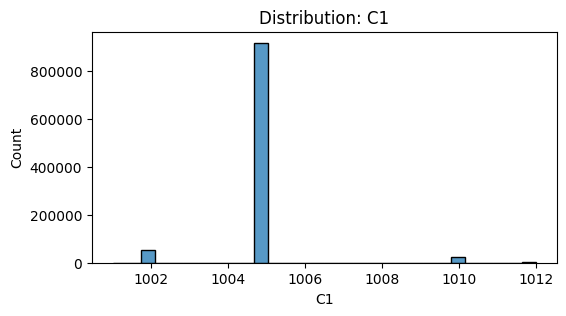

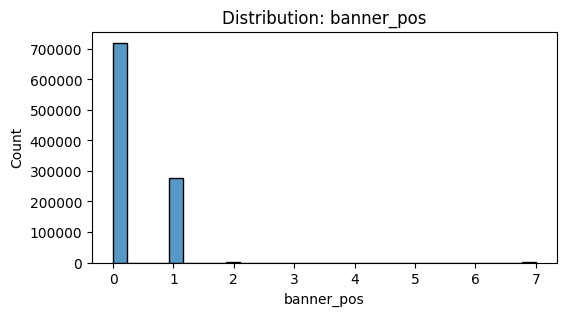

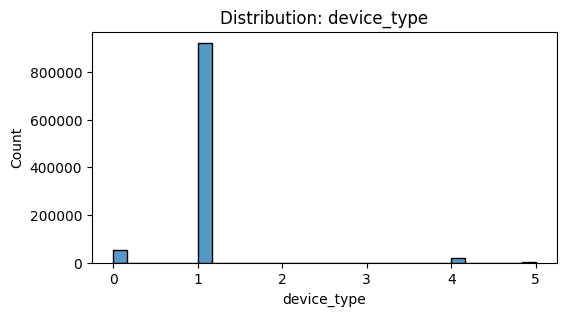

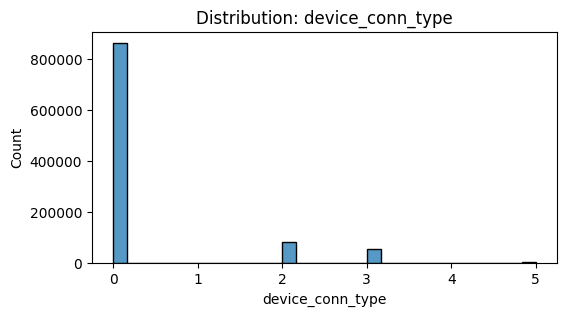

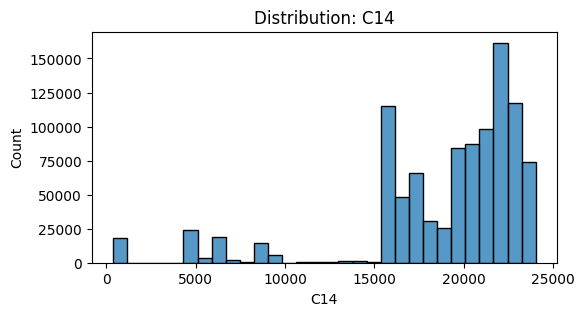

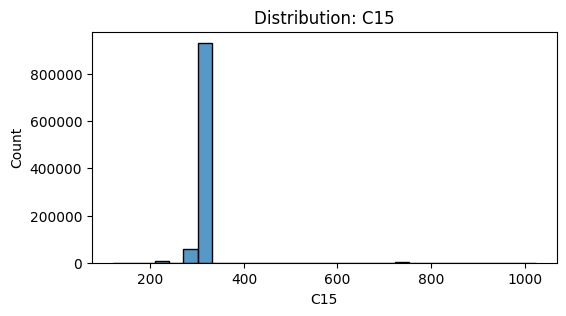

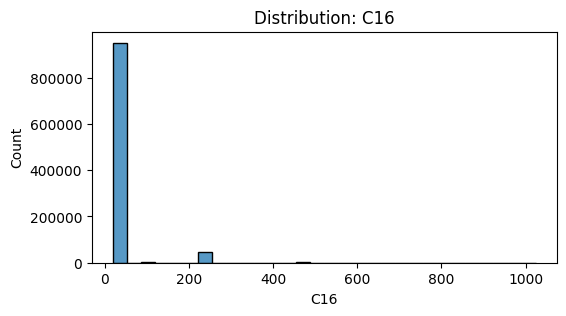

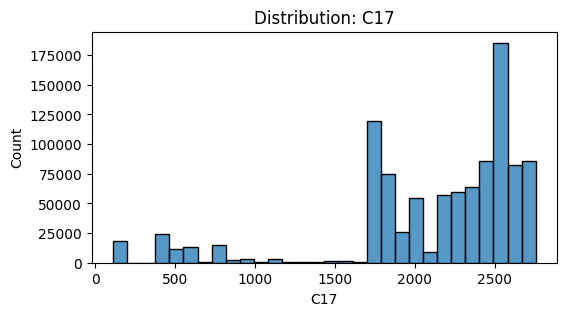

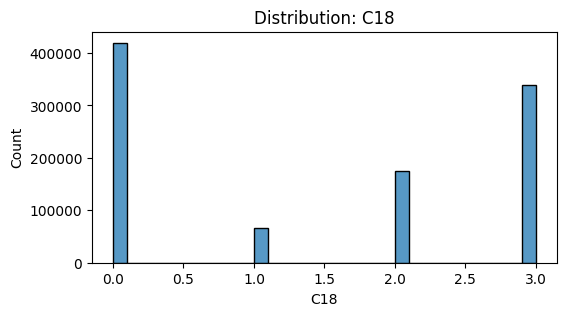

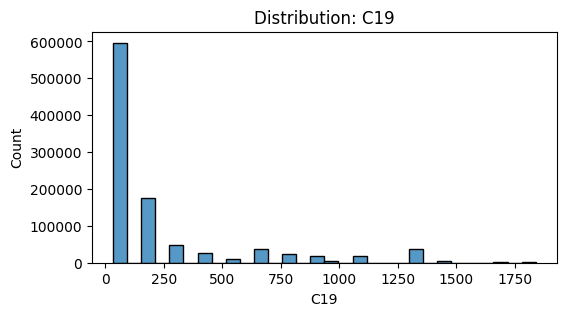

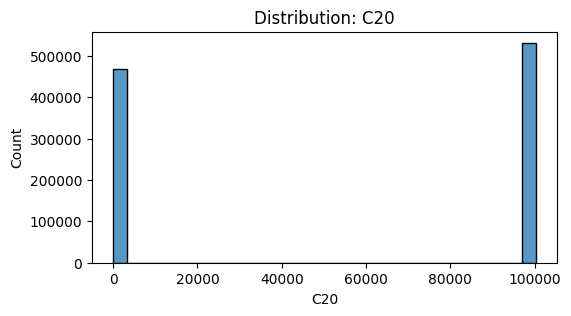

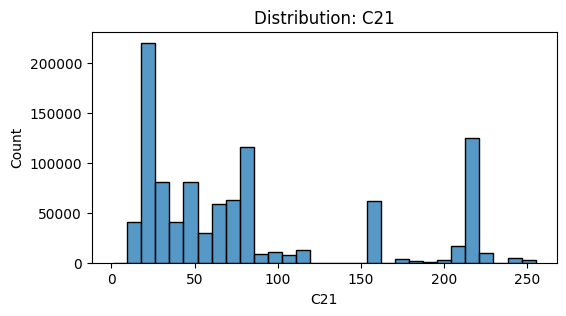

In [21]:
for col in numeric_cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col], bins=30, kde=False)
    plt.title(f'Distribution: {col}')
    plt.show()

<Axes: xlabel='hour', ylabel='click'>

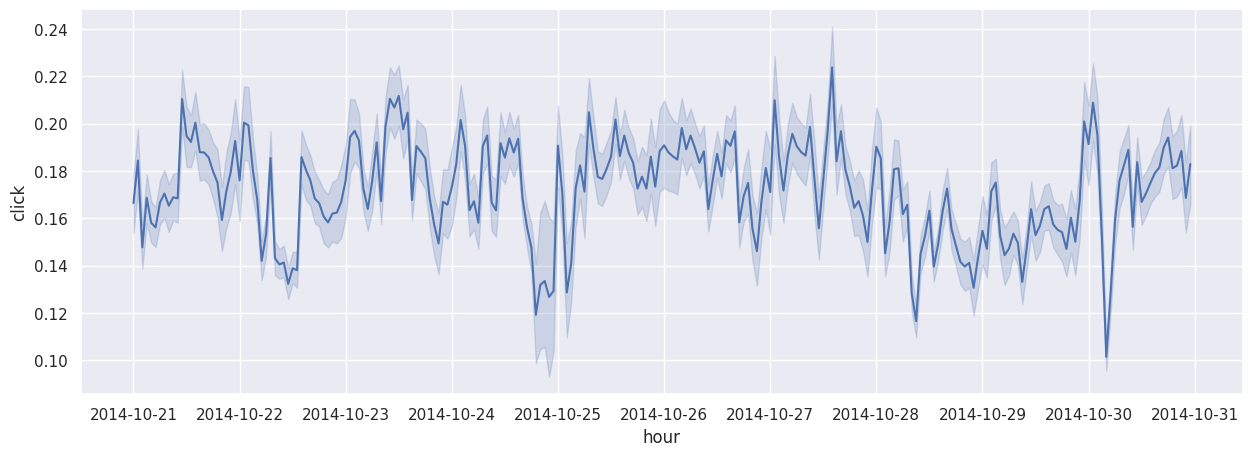

In [22]:
sns.set(rc={'figure.figsize': (15, 5)})

sns.lineplot(data=df, x='hour', y='click')

In [23]:
df['day'] = df['hour'].dt.day
df['weekday'] = df['hour'].dt.weekday
df['hour_of_day'] = df['hour'].dt.hour

In [24]:
val_df = df[df['day'] == 30].copy()
df = df[df['day'] != 30].copy()

<Axes: xlabel='hour', ylabel='click'>

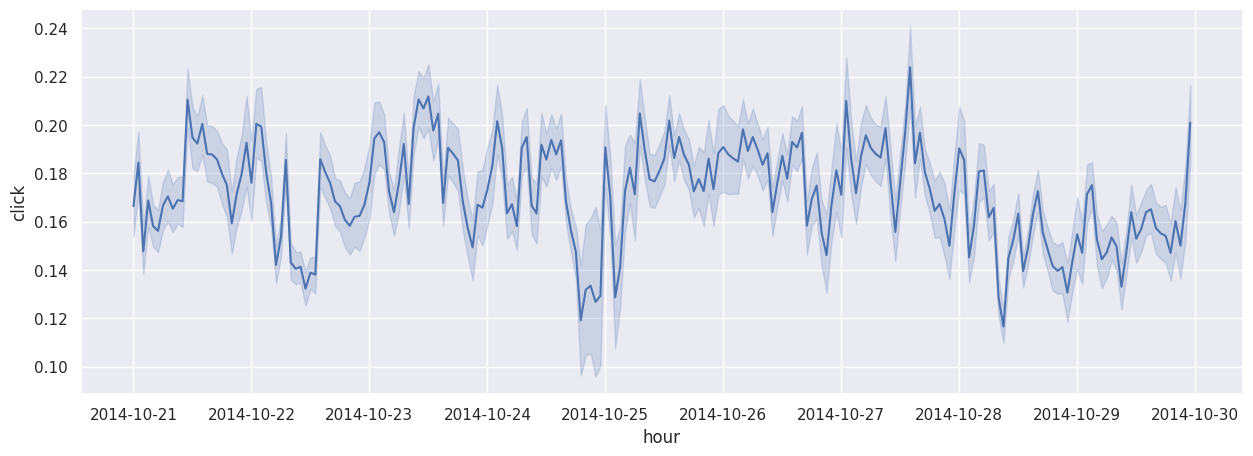

In [25]:
sns.set(rc={'figure.figsize': (15, 5)})

sns.lineplot(data=df, x='hour', y='click')

In [26]:
correlation_matrix = df[numeric_cols].corr(method='pearson')

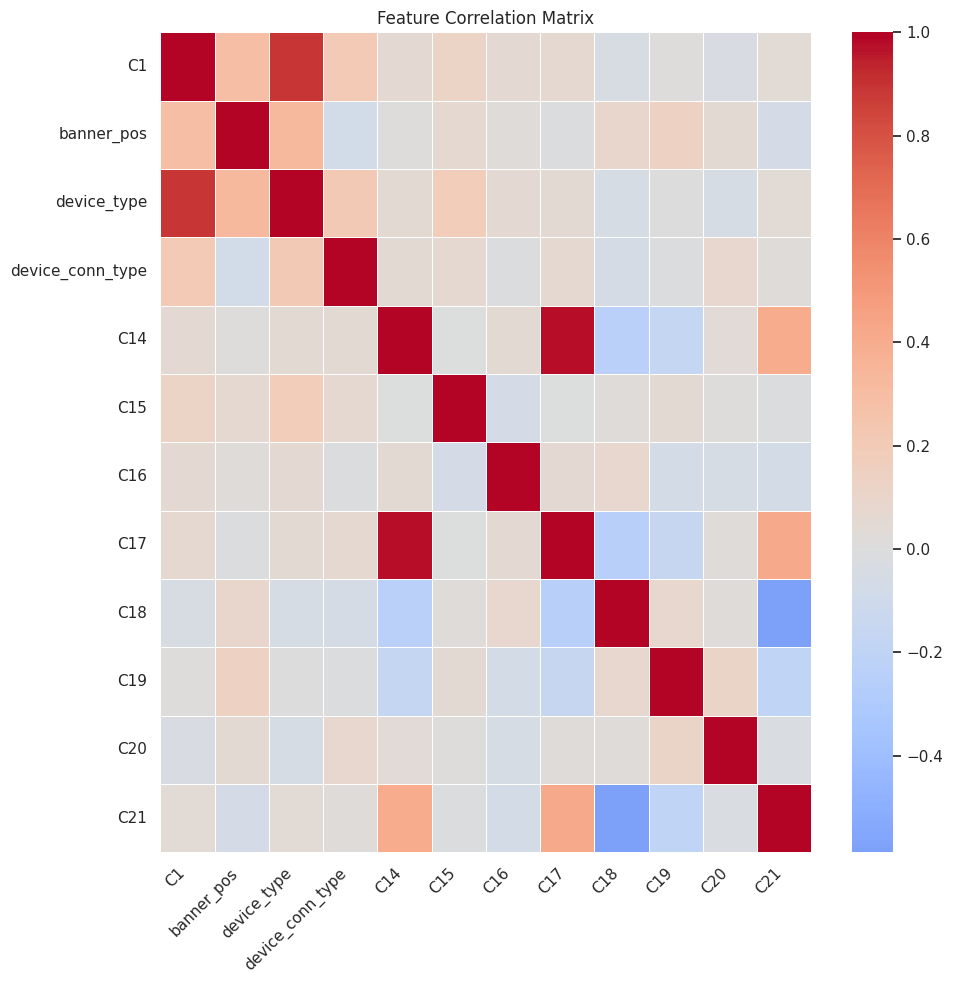

In [27]:
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=False, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [28]:
print("Cardinality of object features:")
for col in cat_cols:
    print(f"{col}: {df[col].nunique()} unique")

Cardinality of object features:
site_id: 2606 unique
site_domain: 2772 unique
site_category: 21 unique
app_id: 3026 unique
app_domain: 196 unique
app_category: 27 unique
device_id: 137236 unique
device_ip: 499845 unique
device_model: 5026 unique


In [29]:
df.drop(['device_id', 'device_ip','hour'], axis=1, inplace=True)

# Feature generation

In [30]:
df = extract_time_features(df)

In [31]:
df.columns.to_list()

['click',
 'C1',
 'banner_pos',
 'site_id',
 'site_domain',
 'site_category',
 'app_id',
 'app_domain',
 'app_category',
 'device_model',
 'device_type',
 'device_conn_type',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19',
 'C20',
 'C21',
 'day',
 'weekday',
 'hour_of_day',
 'hour_sin',
 'hour_cos',
 'ctr_per_hour',
 'ctr_per_day',
 'ctr_hour_norm']

In [32]:
categorical_cols = ['C1', 'banner_pos', 'site_id', 'site_domain', 'site_category',
                        'app_id', 'app_domain', 'app_category', 'device_type','device_model',
                        'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21',
                        'weekday', 'hour_of_day']

numerical_cols = ['hour_sin', 'hour_cos', 'ctr_per_hour', 'ctr_per_day', 'ctr_hour_norm']

In [33]:
for col in categorical_cols:
    freq_map = df[col].value_counts().to_dict()
    df[f'{col}_freq'] = df[col].map(freq_map)

freq_cols = [col for col in df.columns if '_freq' in col]
numerical_cols.extend(freq_cols)

In [34]:
df['site_banner'] = df['site_id'].astype(str) + '_' + df['banner_pos'].astype(str)
df['app_device'] = df['app_id'].astype(str) + '_' + df['device_type'].astype(str)
df['site_app_interaction'] = df['site_id'].astype(str) + '_' + df['app_id'].astype(str)

categorical_cols = categorical_cols + ['site_banner', 'app_device', 'site_app_interaction']

In [35]:
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [36]:
ordinal_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df[categorical_cols] = ordinal_enc.fit_transform(df[categorical_cols])

# Models

In [74]:
X = df.drop(columns=['click'])
y = df['click']
print(X.shape, y.shape)

(895728, 51) (895728,)


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## LightGBM

In [90]:
def lgb_objective(trial, X, y):
    """Objective function for Optuna to optimize LightGBM hyperparameters with cross-validation."""
    scale_pos_weight = (y == 0).sum() / (y == 1).sum()  # Calculate scale_pos_weight
    param = {
        'objective': 'binary',
        'metric': ['precision', 'recall'],
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'num_leaves': trial.suggest_int('num_leaves', 15, 60),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 0.9),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 0.9),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 5),
        'scale_pos_weight': scale_pos_weight,
        'verbose': -1,
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 80),
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 0.1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 0.1),
    }

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []

    for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model = LGBMClassifier(**param)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
        preds = model.predict_proba(X_val)[:, 1]

        precision = precision_score(y_val, (preds > 0.5).astype(int))
        recall = recall_score(y_val, (preds > 0.5).astype(int))
        f1 = f1_score(y_val, (preds > 0.5).astype(int))
        f1_scores.append(f1)

        print(f"Fold {fold + 1} Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    return np.mean(f1_scores)



In [91]:
lgb_study = optuna.create_study(direction="maximize")
lgb_study.optimize(lambda trial: lgb_objective(trial, X, y), n_trials=20)

[I 2025-04-22 13:38:53,337] A new study created in memory with name: no-name-868661fb-5b76-4123-999c-e46ba6f072f7


Fold 1 Precision: 0.2754, Recall: 0.7174, F1: 0.3980
Fold 2 Precision: 0.2764, Recall: 0.7126, F1: 0.3983
Fold 3 Precision: 0.2758, Recall: 0.7178, F1: 0.3985
Fold 4 Precision: 0.2773, Recall: 0.7160, F1: 0.3998


[I 2025-04-22 13:39:14,602] Trial 0 finished with value: 0.39861259002316707 and parameters: {'max_depth': 5, 'learning_rate': 0.016489264165700294, 'num_leaves': 50, 'feature_fraction': 0.6536725783618833, 'bagging_fraction': 0.7148098390472386, 'bagging_freq': 4, 'min_child_samples': 22, 'n_estimators': 283, 'reg_alpha': 0.0547521185481229, 'reg_lambda': 0.040193332343356626}. Best is trial 0 with value: 0.39861259002316707.


Fold 5 Precision: 0.2753, Recall: 0.7216, F1: 0.3986
Fold 1 Precision: 0.4862, Recall: 0.1014, F1: 0.1678
Fold 2 Precision: 0.4994, Recall: 0.0988, F1: 0.1650
Fold 3 Precision: 0.4917, Recall: 0.1000, F1: 0.1662
Fold 4 Precision: 0.4876, Recall: 0.1011, F1: 0.1674


[I 2025-04-22 13:39:26,507] Trial 1 finished with value: 0.16557173476629006 and parameters: {'max_depth': 5, 'learning_rate': 0.007906338796090526, 'num_leaves': 29, 'feature_fraction': 0.7438214398913039, 'bagging_fraction': 0.6265856097315204, 'bagging_freq': 2, 'min_child_samples': 28, 'n_estimators': 113, 'reg_alpha': 0.02597777596629718, 'reg_lambda': 0.006118230643218237}. Best is trial 0 with value: 0.39861259002316707.


Fold 5 Precision: 0.4831, Recall: 0.0970, F1: 0.1615
Fold 1 Precision: 0.2770, Recall: 0.7241, F1: 0.4008
Fold 2 Precision: 0.2786, Recall: 0.7187, F1: 0.4016
Fold 3 Precision: 0.2773, Recall: 0.7262, F1: 0.4014
Fold 4 Precision: 0.2773, Recall: 0.7242, F1: 0.4011


[I 2025-04-22 13:39:44,720] Trial 2 finished with value: 0.4012012021260154 and parameters: {'max_depth': 5, 'learning_rate': 0.028243839304105376, 'num_leaves': 31, 'feature_fraction': 0.6569071953628995, 'bagging_fraction': 0.7712252522009804, 'bagging_freq': 4, 'min_child_samples': 25, 'n_estimators': 224, 'reg_alpha': 0.02069142540333794, 'reg_lambda': 0.03883842216656008}. Best is trial 2 with value: 0.4012012021260154.


Fold 5 Precision: 0.2771, Recall: 0.7266, F1: 0.4012
Fold 1 Precision: 0.2781, Recall: 0.7207, F1: 0.4013
Fold 2 Precision: 0.2785, Recall: 0.7159, F1: 0.4010
Fold 3 Precision: 0.2782, Recall: 0.7220, F1: 0.4016
Fold 4 Precision: 0.2790, Recall: 0.7192, F1: 0.4020


[I 2025-04-22 13:39:57,730] Trial 3 finished with value: 0.40131905358658704 and parameters: {'max_depth': 5, 'learning_rate': 0.04427484946923917, 'num_leaves': 43, 'feature_fraction': 0.7117570543259784, 'bagging_fraction': 0.7368767518199222, 'bagging_freq': 4, 'min_child_samples': 42, 'n_estimators': 146, 'reg_alpha': 0.06247329944430583, 'reg_lambda': 0.05239560226981255}. Best is trial 3 with value: 0.40131905358658704.


Fold 5 Precision: 0.2765, Recall: 0.7276, F1: 0.4007
Fold 1 Precision: 0.2833, Recall: 0.6979, F1: 0.4030
Fold 2 Precision: 0.2834, Recall: 0.6950, F1: 0.4026
Fold 3 Precision: 0.2820, Recall: 0.7018, F1: 0.4023
Fold 4 Precision: 0.2829, Recall: 0.7015, F1: 0.4032


[I 2025-04-22 13:40:15,619] Trial 4 finished with value: 0.40314880511695206 and parameters: {'max_depth': 7, 'learning_rate': 0.02059619688007322, 'num_leaves': 37, 'feature_fraction': 0.7899623670663198, 'bagging_fraction': 0.8172799248246855, 'bagging_freq': 3, 'min_child_samples': 34, 'n_estimators': 160, 'reg_alpha': 0.04481609741106232, 'reg_lambda': 0.05725042422379922}. Best is trial 4 with value: 0.40314880511695206.


Fold 5 Precision: 0.2840, Recall: 0.7028, F1: 0.4046
Fold 1 Precision: 0.2832, Recall: 0.7263, F1: 0.4075
Fold 2 Precision: 0.2824, Recall: 0.7251, F1: 0.4065
Fold 3 Precision: 0.2825, Recall: 0.7315, F1: 0.4076
Fold 4 Precision: 0.2835, Recall: 0.7307, F1: 0.4085


[I 2025-04-22 13:40:37,327] Trial 5 finished with value: 0.4077020449059886 and parameters: {'max_depth': 7, 'learning_rate': 0.03006546255039847, 'num_leaves': 38, 'feature_fraction': 0.8313650362691041, 'bagging_fraction': 0.6703742695969972, 'bagging_freq': 1, 'min_child_samples': 52, 'n_estimators': 250, 'reg_alpha': 0.043286446952849125, 'reg_lambda': 0.01599074955201887}. Best is trial 5 with value: 0.4077020449059886.


Fold 5 Precision: 0.2833, Recall: 0.7309, F1: 0.4083
Fold 1 Precision: 0.2630, Recall: 0.6372, F1: 0.3724
Fold 2 Precision: 0.2654, Recall: 0.6302, F1: 0.3735
Fold 3 Precision: 0.2641, Recall: 0.6327, F1: 0.3727
Fold 4 Precision: 0.2672, Recall: 0.6369, F1: 0.3764


[I 2025-04-22 13:40:49,451] Trial 6 finished with value: 0.37383351818896343 and parameters: {'max_depth': 3, 'learning_rate': 0.01677890545964628, 'num_leaves': 15, 'feature_fraction': 0.7418761405719464, 'bagging_fraction': 0.6205162371386092, 'bagging_freq': 3, 'min_child_samples': 32, 'n_estimators': 199, 'reg_alpha': 0.09115791187686717, 'reg_lambda': 0.06837098780151864}. Best is trial 5 with value: 0.4077020449059886.


Fold 5 Precision: 0.2642, Recall: 0.6406, F1: 0.3741
Fold 1 Precision: 0.2830, Recall: 0.6932, F1: 0.4019
Fold 2 Precision: 0.2836, Recall: 0.6811, F1: 0.4005
Fold 3 Precision: 0.2836, Recall: 0.6871, F1: 0.4015
Fold 4 Precision: 0.2843, Recall: 0.6873, F1: 0.4022


[I 2025-04-22 13:41:04,555] Trial 7 finished with value: 0.4018633777640176 and parameters: {'max_depth': 6, 'learning_rate': 0.02278927598631924, 'num_leaves': 49, 'feature_fraction': 0.6508726001220583, 'bagging_fraction': 0.6506282665540777, 'bagging_freq': 5, 'min_child_samples': 71, 'n_estimators': 136, 'reg_alpha': 0.018749284842826543, 'reg_lambda': 0.07891674772810398}. Best is trial 5 with value: 0.4077020449059886.


Fold 5 Precision: 0.2850, Recall: 0.6892, F1: 0.4032
Fold 1 Precision: 0.3317, Recall: 0.4253, F1: 0.3727
Fold 2 Precision: 0.3317, Recall: 0.4153, F1: 0.3688
Fold 3 Precision: 0.3238, Recall: 0.4359, F1: 0.3716
Fold 4 Precision: 0.3329, Recall: 0.4177, F1: 0.3705


[I 2025-04-22 13:41:19,576] Trial 8 finished with value: 0.3711029571440395 and parameters: {'max_depth': 6, 'learning_rate': 0.012768797791213413, 'num_leaves': 40, 'feature_fraction': 0.8845292661727893, 'bagging_fraction': 0.869165137397399, 'bagging_freq': 3, 'min_child_samples': 44, 'n_estimators': 127, 'reg_alpha': 0.05934956795476916, 'reg_lambda': 0.04966420713395101}. Best is trial 5 with value: 0.4077020449059886.


Fold 5 Precision: 0.3245, Recall: 0.4355, F1: 0.3719
Fold 1 Precision: 0.2817, Recall: 0.7091, F1: 0.4032
Fold 2 Precision: 0.2804, Recall: 0.7068, F1: 0.4015
Fold 3 Precision: 0.2810, Recall: 0.7128, F1: 0.4031
Fold 4 Precision: 0.2819, Recall: 0.7110, F1: 0.4037


[I 2025-04-22 13:41:32,631] Trial 9 finished with value: 0.40322510257018973 and parameters: {'max_depth': 7, 'learning_rate': 0.03397511310656932, 'num_leaves': 31, 'feature_fraction': 0.7006739682116245, 'bagging_fraction': 0.7393769328761156, 'bagging_freq': 4, 'min_child_samples': 64, 'n_estimators': 111, 'reg_alpha': 0.02543518522546513, 'reg_lambda': 0.008867909836982291}. Best is trial 5 with value: 0.4077020449059886.


Fold 5 Precision: 0.2826, Recall: 0.7128, F1: 0.4047
Fold 1 Precision: 0.2733, Recall: 0.7093, F1: 0.3946
Fold 2 Precision: 0.2719, Recall: 0.7065, F1: 0.3927
Fold 3 Precision: 0.2718, Recall: 0.7126, F1: 0.3936
Fold 4 Precision: 0.2737, Recall: 0.7114, F1: 0.3953


[I 2025-04-22 13:41:46,464] Trial 10 finished with value: 0.3941715545067947 and parameters: {'max_depth': 3, 'learning_rate': 0.03967512494240379, 'num_leaves': 59, 'feature_fraction': 0.8373569195050646, 'bagging_fraction': 0.6827329391338919, 'bagging_freq': 1, 'min_child_samples': 58, 'n_estimators': 279, 'reg_alpha': 0.08438230566532873, 'reg_lambda': 0.09680957342767546}. Best is trial 5 with value: 0.4077020449059886.


Fold 5 Precision: 0.2731, Recall: 0.7114, F1: 0.3947
Fold 1 Precision: 0.2815, Recall: 0.7240, F1: 0.4054
Fold 2 Precision: 0.2801, Recall: 0.7218, F1: 0.4036
Fold 3 Precision: 0.2800, Recall: 0.7277, F1: 0.4044
Fold 4 Precision: 0.2809, Recall: 0.7276, F1: 0.4054


[I 2025-04-22 13:42:05,140] Trial 11 finished with value: 0.4048477575722692 and parameters: {'max_depth': 7, 'learning_rate': 0.03198373205756133, 'num_leaves': 24, 'feature_fraction': 0.8139585027702597, 'bagging_fraction': 0.7886957215417707, 'bagging_freq': 1, 'min_child_samples': 61, 'n_estimators': 232, 'reg_alpha': 0.003292812469945963, 'reg_lambda': 0.0009716801748903964}. Best is trial 5 with value: 0.4077020449059886.


Fold 5 Precision: 0.2808, Recall: 0.7297, F1: 0.4056
Fold 1 Precision: 0.2796, Recall: 0.7238, F1: 0.4034
Fold 2 Precision: 0.2796, Recall: 0.7214, F1: 0.4030
Fold 3 Precision: 0.2791, Recall: 0.7275, F1: 0.4034
Fold 4 Precision: 0.2802, Recall: 0.7274, F1: 0.4046


[I 2025-04-22 13:42:23,076] Trial 12 finished with value: 0.40376569475160495 and parameters: {'max_depth': 7, 'learning_rate': 0.03172479474558339, 'num_leaves': 19, 'feature_fraction': 0.8060542884440953, 'bagging_fraction': 0.8023686527785461, 'bagging_freq': 1, 'min_child_samples': 55, 'n_estimators': 242, 'reg_alpha': 0.001038082299691441, 'reg_lambda': 0.023515012446068906}. Best is trial 5 with value: 0.4077020449059886.


Fold 5 Precision: 0.2791, Recall: 0.7335, F1: 0.4044
Fold 1 Precision: 0.2813, Recall: 0.7239, F1: 0.4051
Fold 2 Precision: 0.2813, Recall: 0.7227, F1: 0.4050
Fold 3 Precision: 0.2815, Recall: 0.7273, F1: 0.4059
Fold 4 Precision: 0.2811, Recall: 0.7293, F1: 0.4058


[I 2025-04-22 13:42:42,029] Trial 13 finished with value: 0.40553925938972785 and parameters: {'max_depth': 6, 'learning_rate': 0.03633757472968525, 'num_leaves': 23, 'feature_fraction': 0.8734925376554867, 'bagging_fraction': 0.8628193126234638, 'bagging_freq': 1, 'min_child_samples': 72, 'n_estimators': 246, 'reg_alpha': 0.009898002443847604, 'reg_lambda': 0.021463825788942598}. Best is trial 5 with value: 0.4077020449059886.


Fold 5 Precision: 0.2811, Recall: 0.7299, F1: 0.4059
Fold 1 Precision: 0.2832, Recall: 0.7247, F1: 0.4073
Fold 2 Precision: 0.2817, Recall: 0.7239, F1: 0.4055
Fold 3 Precision: 0.2821, Recall: 0.7292, F1: 0.4068
Fold 4 Precision: 0.2822, Recall: 0.7306, F1: 0.4071


[I 2025-04-22 13:43:03,685] Trial 14 finished with value: 0.40709892381758356 and parameters: {'max_depth': 6, 'learning_rate': 0.04720960316348941, 'num_leaves': 23, 'feature_fraction': 0.8736198018383079, 'bagging_fraction': 0.8922231892099652, 'bagging_freq': 2, 'min_child_samples': 79, 'n_estimators': 256, 'reg_alpha': 0.03985453971062099, 'reg_lambda': 0.025003001535664225}. Best is trial 5 with value: 0.4077020449059886.


Fold 5 Precision: 0.2839, Recall: 0.7295, F1: 0.4088
Fold 1 Precision: 0.2829, Recall: 0.7264, F1: 0.4073
Fold 2 Precision: 0.2824, Recall: 0.7255, F1: 0.4065
Fold 3 Precision: 0.2821, Recall: 0.7290, F1: 0.4068
Fold 4 Precision: 0.2835, Recall: 0.7297, F1: 0.4084


[I 2025-04-22 13:43:23,547] Trial 15 finished with value: 0.40762546166640423 and parameters: {'max_depth': 6, 'learning_rate': 0.0493695869690331, 'num_leaves': 36, 'feature_fraction': 0.8556509343901867, 'bagging_fraction': 0.8966417193281194, 'bagging_freq': 2, 'min_child_samples': 77, 'n_estimators': 193, 'reg_alpha': 0.03981990900114735, 'reg_lambda': 0.02536856211133766}. Best is trial 5 with value: 0.4077020449059886.


Fold 5 Precision: 0.2842, Recall: 0.7304, F1: 0.4092
Fold 1 Precision: 0.2753, Recall: 0.7171, F1: 0.3979
Fold 2 Precision: 0.2756, Recall: 0.7132, F1: 0.3976
Fold 3 Precision: 0.2743, Recall: 0.7210, F1: 0.3974
Fold 4 Precision: 0.2756, Recall: 0.7216, F1: 0.3989


[I 2025-04-22 13:43:37,296] Trial 16 finished with value: 0.3979889039466618 and parameters: {'max_depth': 4, 'learning_rate': 0.042603186412589644, 'num_leaves': 37, 'feature_fraction': 0.8419333736061311, 'bagging_fraction': 0.6859320534886533, 'bagging_freq': 2, 'min_child_samples': 48, 'n_estimators': 187, 'reg_alpha': 0.07402884951082836, 'reg_lambda': 0.016900098820710877}. Best is trial 5 with value: 0.4077020449059886.


Fold 5 Precision: 0.2749, Recall: 0.7220, F1: 0.3982
Fold 1 Precision: 0.2842, Recall: 0.7276, F1: 0.4088
Fold 2 Precision: 0.2825, Recall: 0.7266, F1: 0.4069
Fold 3 Precision: 0.2830, Recall: 0.7316, F1: 0.4082
Fold 4 Precision: 0.2835, Recall: 0.7328, F1: 0.4089


[I 2025-04-22 13:43:58,791] Trial 17 finished with value: 0.4084983784901623 and parameters: {'max_depth': 6, 'learning_rate': 0.04936248012638717, 'num_leaves': 47, 'feature_fraction': 0.7758987636281284, 'bagging_fraction': 0.8367505173132285, 'bagging_freq': 2, 'min_child_samples': 79, 'n_estimators': 210, 'reg_alpha': 0.03567427158567276, 'reg_lambda': 0.0344193720808627}. Best is trial 17 with value: 0.4084983784901623.


Fold 5 Precision: 0.2843, Recall: 0.7335, F1: 0.4098
Fold 1 Precision: 0.2727, Recall: 0.7090, F1: 0.3939
Fold 2 Precision: 0.2717, Recall: 0.7045, F1: 0.3922
Fold 3 Precision: 0.2717, Recall: 0.7104, F1: 0.3930
Fold 4 Precision: 0.2720, Recall: 0.7115, F1: 0.3935


[I 2025-04-22 13:44:15,028] Trial 18 finished with value: 0.3933076925486666 and parameters: {'max_depth': 4, 'learning_rate': 0.023774557637073968, 'num_leaves': 47, 'feature_fraction': 0.7874307543802802, 'bagging_fraction': 0.8338143543748137, 'bagging_freq': 2, 'min_child_samples': 66, 'n_estimators': 215, 'reg_alpha': 0.03493119207506393, 'reg_lambda': 0.03611091619832238}. Best is trial 17 with value: 0.4084983784901623.


Fold 5 Precision: 0.2730, Recall: 0.7068, F1: 0.3939
Fold 1 Precision: 0.2871, Recall: 0.7326, F1: 0.4125
Fold 2 Precision: 0.2858, Recall: 0.7266, F1: 0.4102
Fold 3 Precision: 0.2864, Recall: 0.7355, F1: 0.4123
Fold 4 Precision: 0.2862, Recall: 0.7331, F1: 0.4117


[I 2025-04-22 13:44:42,983] Trial 19 finished with value: 0.41177956322366543 and parameters: {'max_depth': 7, 'learning_rate': 0.03789391662253511, 'num_leaves': 60, 'feature_fraction': 0.762000015156024, 'bagging_fraction': 0.6550608996667431, 'bagging_freq': 1, 'min_child_samples': 55, 'n_estimators': 299, 'reg_alpha': 0.05087775076692198, 'reg_lambda': 0.03320162040985247}. Best is trial 19 with value: 0.41177956322366543.


Fold 5 Precision: 0.2866, Recall: 0.7332, F1: 0.4121


In [92]:
best_lgb = LGBMClassifier(**lgb_study.best_params)
best_lgb.fit(X_train, y_train)
y_test_lgb = best_lgb.predict_proba(X_test)[:, 1]


LightGBM Metrics
ROC AUC: 0.7431911217824616
F1 Score: 0.12345314392037568
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.99      0.91    148718
           1       0.61      0.07      0.12     30428

    accuracy                           0.83    179146
   macro avg       0.72      0.53      0.52    179146
weighted avg       0.80      0.83      0.78    179146



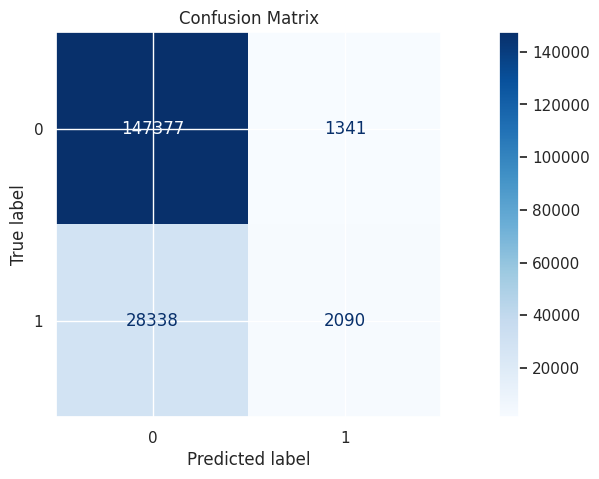

In [93]:
log_metrics("LightGBM", y_test, y_test_lgb)

## DeepFM

In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [77]:
fixlen_feature_columns = [
    SparseFeat(feat, vocabulary_size=df[feat].nunique() + 1, embedding_dim=10)
    for feat in categorical_cols
] + [
    DenseFeat(feat, 1) for feat in numerical_cols
]
feature_names = get_feature_names(fixlen_feature_columns)

train_input = {name: X_train[name].values for name in feature_names}
test_input = {name: X_test[name].values for name in feature_names}

In [78]:
model = DeepFM(
    linear_feature_columns=fixlen_feature_columns,
    dnn_feature_columns=fixlen_feature_columns,
    task='binary'
)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["binary_logloss", "auc"]
)

In [81]:
model.fit(
    train_input, y_train.astype(np.float32).values,
    batch_size=2048,
    epochs=10,
    verbose=2,
    validation_data=(test_input, y_test.astype(np.float32).values)
)

cpu
Train on 716582 samples, validate on 179146 samples, 350 steps per epoch
Epoch 1/10
32s - loss:  0.4123 - auc:  0.7195 - val_auc:  0.7464
Epoch 2/10
32s - loss:  0.3943 - auc:  0.7536 - val_auc:  0.7476
Epoch 3/10
32s - loss:  0.3910 - auc:  0.7594 - val_auc:  0.7478
Epoch 4/10
32s - loss:  0.3887 - auc:  0.7633 - val_auc:  0.7485
Epoch 5/10
32s - loss:  0.3868 - auc:  0.7665 - val_auc:  0.7473
Epoch 6/10
32s - loss:  0.3851 - auc:  0.7694 - val_auc:  0.7469
Epoch 7/10
32s - loss:  0.3833 - auc:  0.7720 - val_auc:  0.7473
Epoch 8/10
32s - loss:  0.3817 - auc:  0.7746 - val_auc:  0.7459
Epoch 9/10
32s - loss:  0.3802 - auc:  0.7769 - val_auc:  0.7454
Epoch 10/10
33s - loss:  0.3788 - auc:  0.7790 - val_auc:  0.7447


In [83]:
preds = model.predict(test_input, batch_size=2048)


DeepFM CTR Metrics
ROC AUC: 0.7446628812181595
F1 Score: 0.18235407542076412
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.98      0.91    148718
           1       0.56      0.11      0.18     30428

    accuracy                           0.83    179146
   macro avg       0.70      0.55      0.55    179146
weighted avg       0.80      0.83      0.78    179146



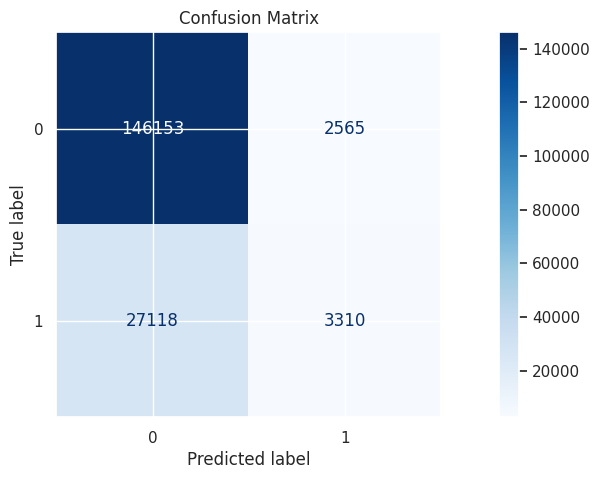

In [84]:
log_metrics("DeepFM CTR", y_test, preds)

# pca

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


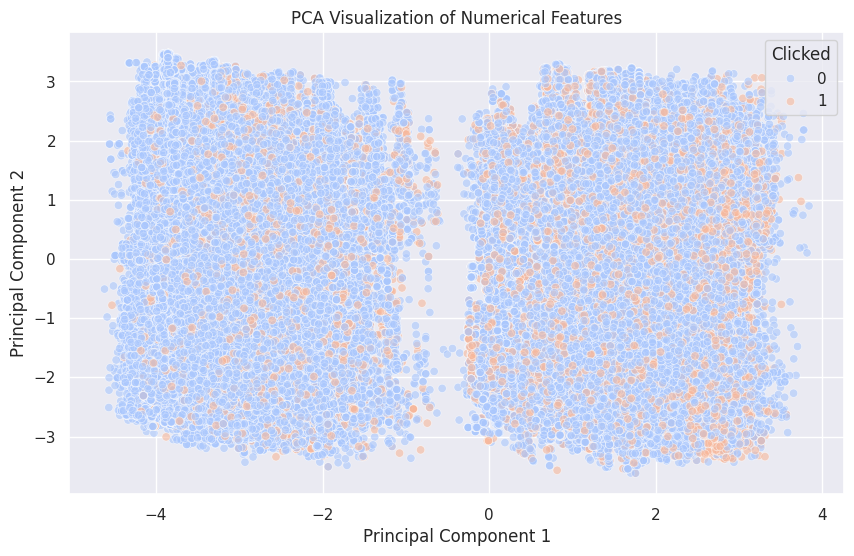

In [85]:
from sklearn.decomposition import PCA

X_num = df[numerical_cols]

X_num = StandardScaler().fit_transform(X_num)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_num)

pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'CTR': y.values
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='CTR', palette='coolwarm', alpha=0.6)
plt.title("PCA Visualization of Numerical Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Clicked')
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


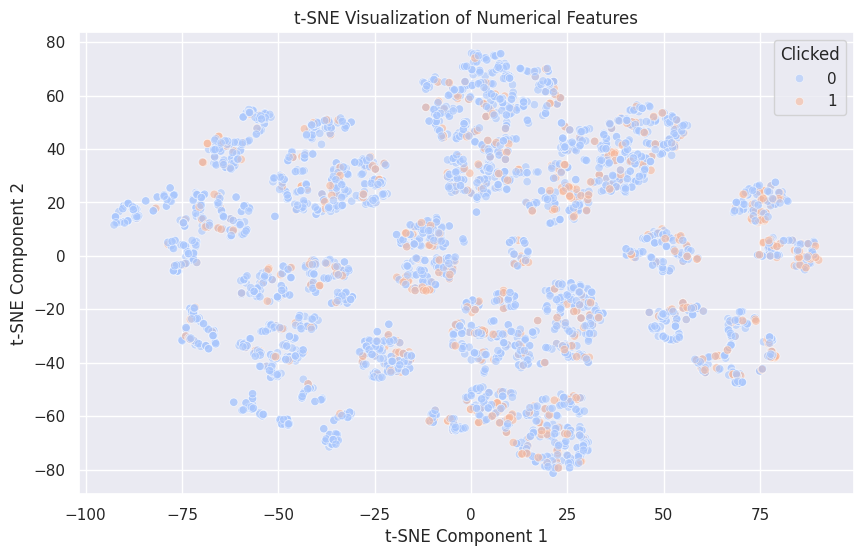

In [89]:
from sklearn.manifold import TSNE

X_num = df[numerical_cols]

sample_size = 5000
X_sample = X_num.sample(n=sample_size, random_state=42)
y_sample = y.loc[X_sample.index]


tsne = TSNE(n_components=2, perplexity=25, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_sample)


tsne_df = pd.DataFrame({
    'TSNE-1': X_tsne[:, 0],
    'TSNE-2': X_tsne[:, 1],
    'CTR': y_sample.values
})


plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x='TSNE-1', y='TSNE-2', hue='CTR', palette='coolwarm', alpha=0.6)
plt.title("t-SNE Visualization of Numerical Features")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title='Clicked')
plt.grid(True)
plt.show()
